In [5]:
# call libraries
using Ipopt, JuMP, PyPlot, Distributions

# set of times
 N=100; Tf=10; h=Tf/N; T=1:N; Tm=1:N-1;
# set time vector
time=zeros(N); for t=1:N time[t] = h*(t-1); end
# set of scenarios
NS=3; S=1:NS;
# problem data
 K = 1.0; x0 = 0.0;  τ = 1.0;
# generate random set-point scenarios
srand(0)
μ = 0; σ = 2; d = Normal(μ,σ);
xsp = rand(d,NS);

# Create JuMP model object
m = Model(solver=IpoptSolver())

# variables (states and inputs)
@variable(m,-2.5<=x[T,S]<=2.5)
@variable(m,-2.0<=u[T,S]<=2.0)
@variable(m, ϵ[T,S])
@variable(m, I[T,S])
@variable(m, C[T,S])

# variables (controller design) 
@variable(m, -10<= Kc <=10)
@variable(m,   0<= τI <=100)
@variable(m,   0<= τD <=1000)

# constraints
@constraint(m, [t in Tm, s in S],(1/τ)*(x[t+1,s]-x[t,s])/h + x[t+1,s]== K*u[t+1,s]);
@constraint(m, [t in Tm, s in S], u[t,s] == Kc*ϵ[t,s]+ τI*I[t,s] + τD*(ϵ[t+1,s]-ϵ[t,s])/h);
@constraint(m, [t in Tm, s in S], (I[t+1,s]-I[t,s])/h == ϵ[t,s]);
@constraint(m, [t in T , s in S], ϵ[t,s]==(xsp[s]-x[t,s]));
@constraint(m, [s in S], x[1,s] == 0);
@constraint(m, [s in S], I[1,s] == 0);
@constraint(m, [t in T, s in S], C[t,s]==(100*ϵ[t,s]^2 + 0.01*u[t,s]^2));

# objective function
@objective(m, Min, sum(C[t,s] for t in T,s in S));

# solve problem 
solve(m)

# display results
println(getvalue(Kc))
println(getvalue(τI))
println(getvalue(τD))

# plot responses
x=zeros(NS,N)
for s in 1:NS
    for j=1:N
       x[s,j]=getvalue(getindex(m,:x)[j,s]) 
    end
end

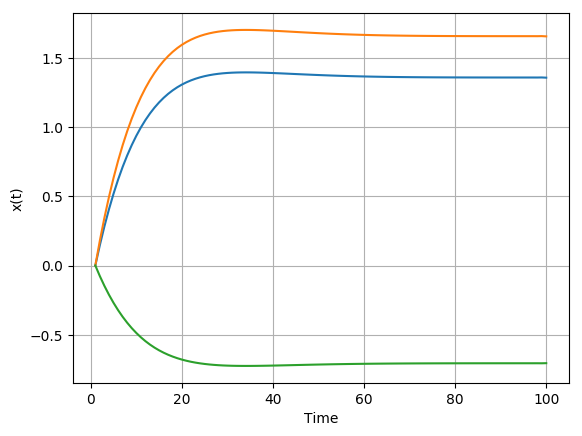

This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     6561
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1788

Total number of variables............................:     1503
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      603
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1497
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [6]:
plot(T, x[1,:]); plot(T, x[2,:]); plot(T, x[3,:]);
xlabel("Time"); ylabel("x(t)"); grid("on"); 
savefig("PID.pdf")